In [1]:
import pandas as pd

# Baca dataset (ubah sesuai path)
df = pd.read_csv("Dataset/data_bersih.csv", delimiter=";")

def label_diabetes(row):
    # Aturan dari labeling.pdf (halaman 2)
    if row['hba1c'] >= 6.5 or row['fgb'] >= 7.0:
        return "Diabetes"
    elif (5.7 <= row['hba1c'] < 6.5) or (5.6 <= row['fgb'] < 6.9):
        return "Prediabetes"
    else:
        return "Non-diabetes"

# Tambah kolom Status
df['Status'] = df.apply(label_diabetes, axis=1)

# Cek distribusi label
print(df['Status'].value_counts())

# Simpan dataset baru (opsional)
df.to_csv("data_labeled.csv", index=False)


Status
Diabetes        2941
Prediabetes     1302
Non-diabetes    1295
Name: count, dtype: int64


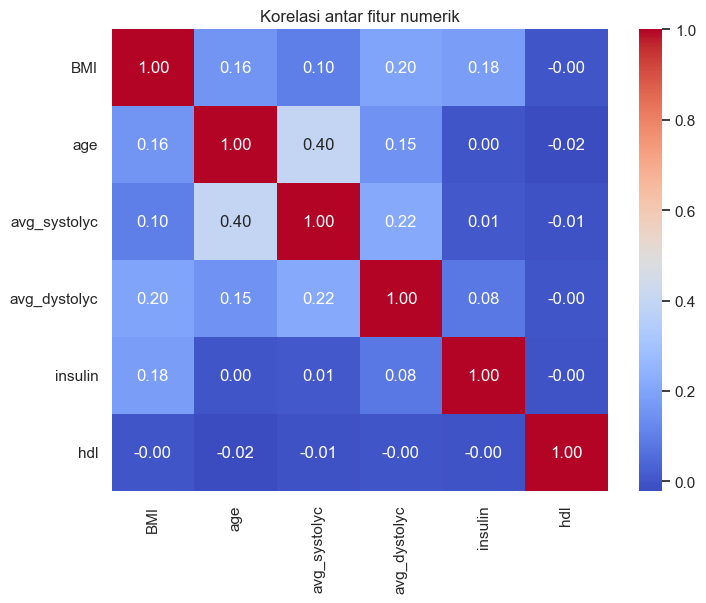

In [15]:
X = df[['BMI', 'age', 'avg_systolyc', 'avg_dystolyc', 'insulin','hdl']]
y = df['Status']

import seaborn as sns
import matplotlib.pyplot as plt

features = ['BMI', 'age', 'avg_systolyc', 'avg_dystolyc', 'insulin','hdl']

corr_matrix = df[features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi antar fitur numerik")
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

# --- 1. Copy data untuk cleaning ---

df_clean = df.copy()

# Buang error input (outlier yang jelas salah, bukan medis ekstrem)
df_clean = df_clean[df_clean['tinggi'] > 80]        # tinggi minimal 80 cm
df_clean = df_clean[df_clean['berat'] > 10]         # berat minimal 10 kg
df_clean = df_clean[df_clean['BMI'] < 70]           # buang BMI ekstrem
df_clean = df_clean[df_clean['insulin'] < 2000]     # insulin wajar
df_clean = df_clean[(df_clean['age'] > 0) & (df_clean['age'] < 100)]  # usia wajar

print(f"Jumlah data awal: {df.shape[0]}")
print(f"Jumlah data setelah cleaning: {df_clean.shape[0]}")


df_clean['insulin_log'] = np.log1p(df_clean['insulin'])  

# --- 3. Scaling dengan RobustScaler ---
scaler = RobustScaler()
num_cols = ['berat','tinggi','BMI','age','insulin_log',
            'avg_systolyc','avg_dystolyc','hdl']

df_scaled = df_clean.copy()
df_scaled[num_cols] = scaler.fit_transform(df_clean[num_cols])

# --- 4. Simpan hasil scaling ---
df_scaled.to_csv("data_scaled.csv", index=False)

print("\n Hasil scaling:")
print(df_scaled[num_cols].head())


Jumlah data awal: 5538
Jumlah data setelah cleaning: 5514

 Hasil scaling:
      berat    tinggi       BMI       age  insulin_log  avg_systolyc  \
0  0.319298  0.903448 -0.087273 -0.257143     0.599974      0.659091   
1  0.842105  0.537931  0.648951  0.400000     1.123916     -0.090909   
2 -0.294737 -0.931034  0.217063 -0.228571     0.705801     -0.409091   
3  0.449123  0.475862  0.270769 -0.514286    -0.053707      0.022727   
4  0.901754 -0.724138  1.659301  0.457143     0.115182      1.272727   

   avg_dystolyc       hdl  
0      1.419355 -0.409091  
1      0.193548  0.477273  
2      0.322581 -0.159091  
3      0.096774 -0.340909  
4      0.322581 -0.568182  


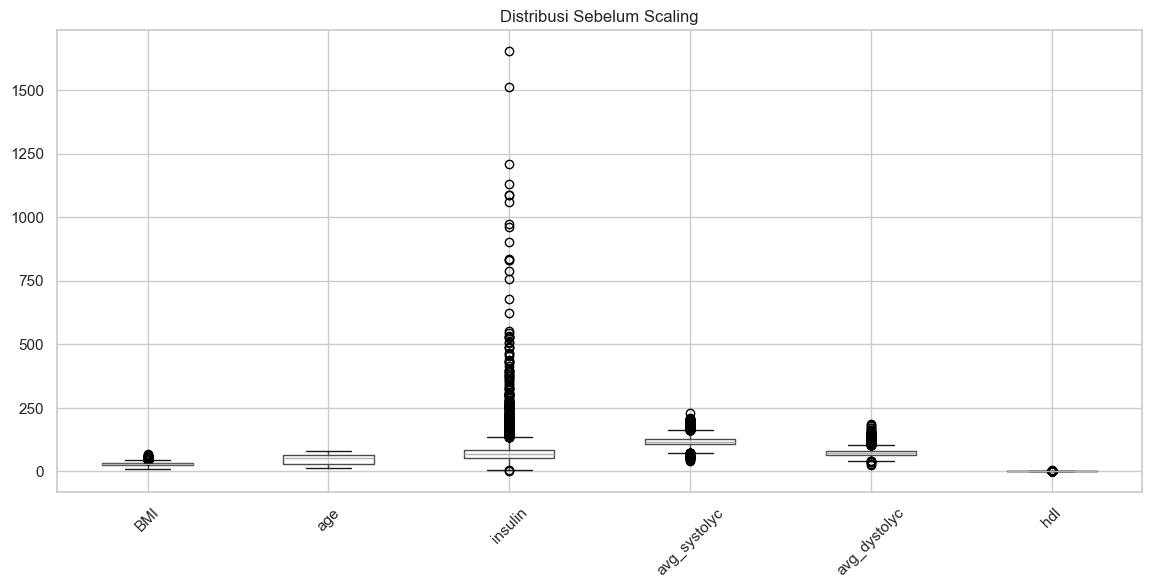

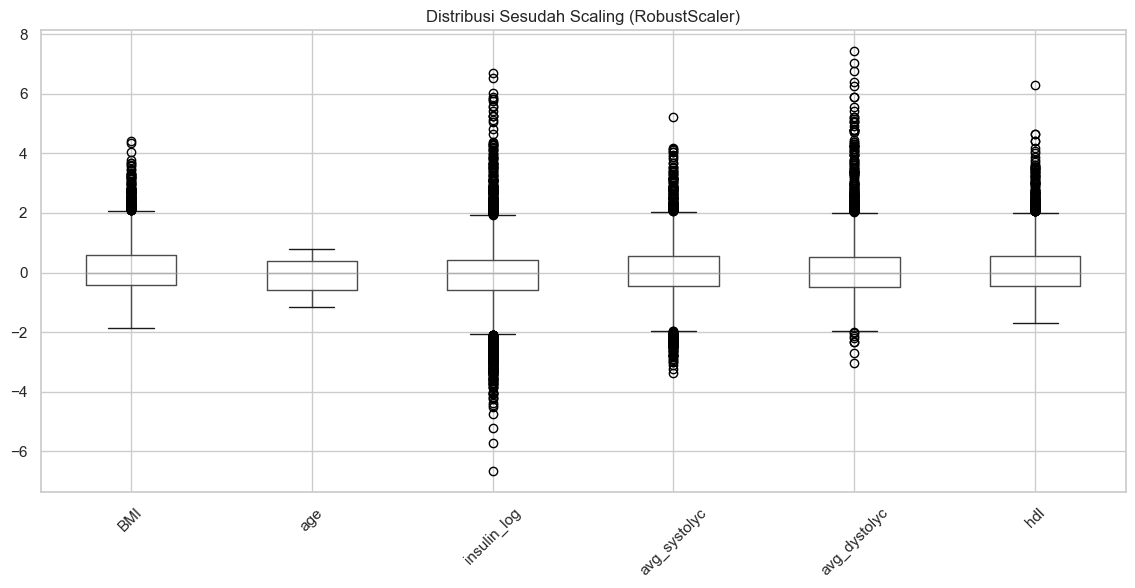

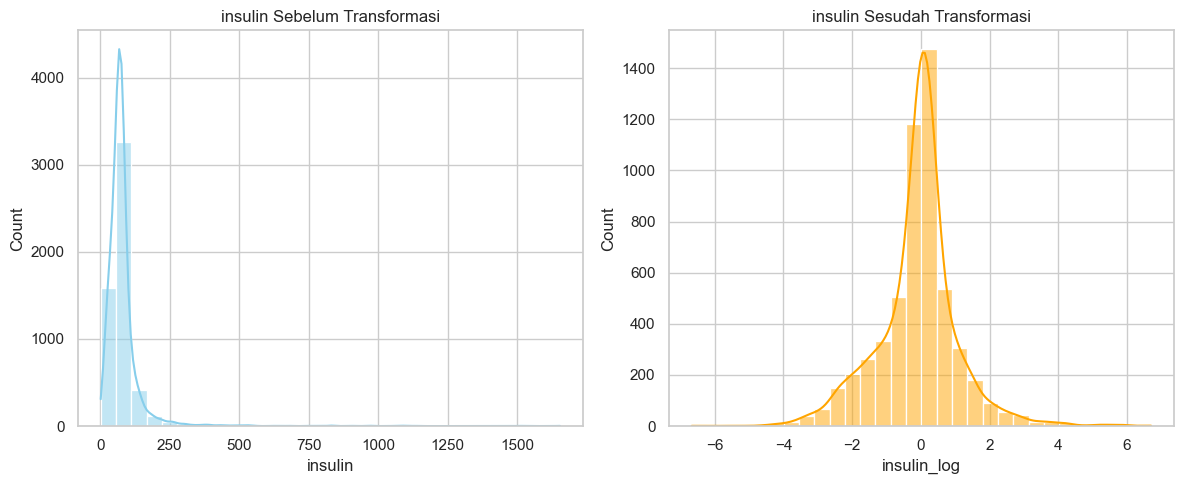

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Atur style biar lebih enak dilihat
sns.set(style="whitegrid")

# Kolom numerik yang mau dicek
num_cols = ['BMI','age','insulin','avg_systolyc','avg_dystolyc','hdl']

# --- 1. Boxplot sebelum scaling ---
plt.figure(figsize=(14,6))
df_clean[num_cols].boxplot()
plt.title("Distribusi Sebelum Scaling")
plt.xticks(rotation=45)
plt.show()

# --- 2. Boxplot sesudah scaling ---
plt.figure(figsize=(14,6))
df_scaled[[c if c!="insulin" else "insulin_log" for c in num_cols]].boxplot()
plt.title("Distribusi Sesudah Scaling (RobustScaler)")
plt.xticks(rotation=45)
plt.show()

# --- 3. Histogram contoh sebelum vs sesudah (misal BMI) ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df_clean['insulin'], bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("insulin Sebelum Transformasi")

sns.histplot(df_scaled['insulin_log'], bins=30, kde=True, ax=axes[1], color="orange")
axes[1].set_title("insulin Sesudah Transformasi")

plt.tight_layout()
plt.show()


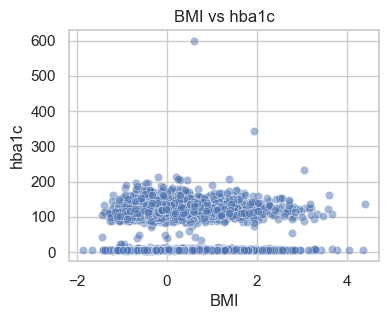

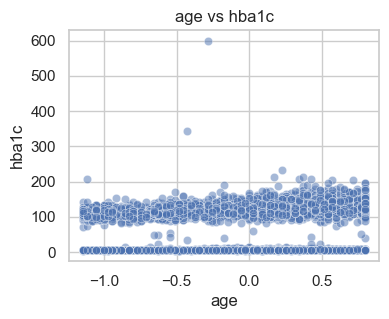

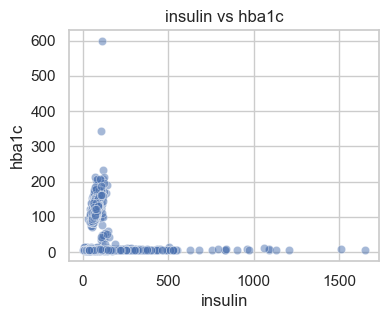

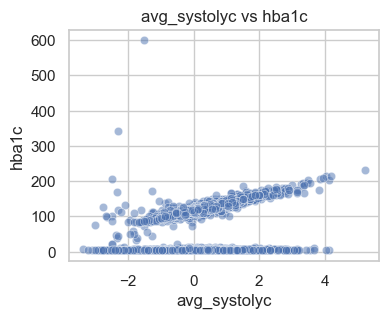

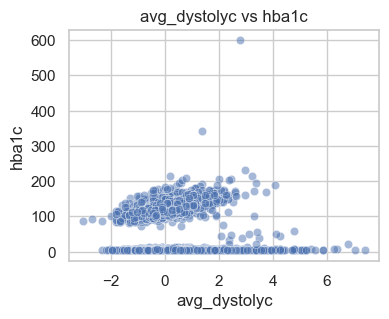

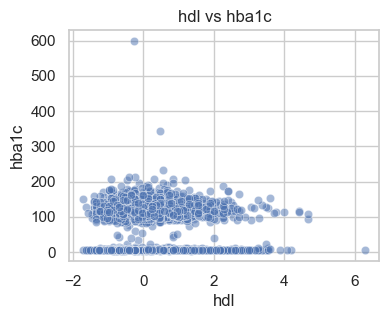

        Feature  Pearson (linear)  Spearman (monotonic)
0           BMI             0.036                 0.130
1           age             0.026                 0.203
2       insulin            -0.056                 0.292
3  avg_systolyc             0.203                 0.326
4  avg_dystolyc             0.021                 0.153
5           hdl            -0.017                -0.015


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Misalnya dataset kamu sudah di df_scaled
# Target (misalnya HbA1c untuk labeling)
target = "hba1c"
features = ["BMI","age","insulin","avg_systolyc","avg_dystolyc","hdl"]

results = []

for col in features:
    # Hitung korelasi Pearson & Spearman
    pearson_corr, _ = pearsonr(df_scaled[col], df_scaled[target])
    spearman_corr, _ = spearmanr(df_scaled[col], df_scaled[target])
    
    results.append({
        "Feature": col,
        "Pearson (linear)": round(pearson_corr, 3),
        "Spearman (monotonic)": round(spearman_corr, 3)
    })
    
    # Scatter plot
    plt.figure(figsize=(4,3))
    sns.scatterplot(x=df_scaled[col], y=df_scaled[target], alpha=0.5)
    plt.title(f"{col} vs {target}")
    plt.show()

# Tabel hasil
results_df = pd.DataFrame(results)
print(results_df)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_37840\2656412547.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Fitur", data=feat_imp, palette="viridis")


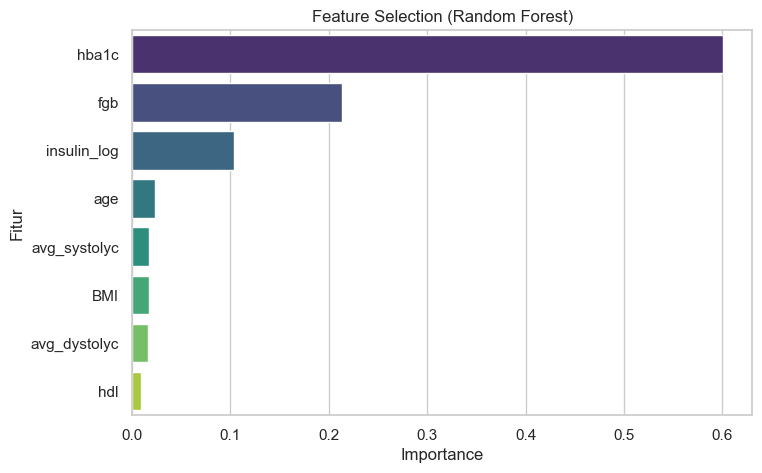

          Fitur  Importance
3         hba1c    0.600398
2           fgb    0.213734
4   insulin_log    0.103233
1           age    0.023511
5  avg_systolyc    0.017462
0           BMI    0.017392
6  avg_dystolyc    0.015752
7           hdl    0.008517


In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Pisahkan fitur dan label ---
X = df_scaled[['BMI','age','fgb','hba1c','insulin_log','avg_systolyc','avg_dystolyc','hdl']]
y = df_scaled['Status']   # pastikan ini sudah kategori/label

# --- 2. Encode label jadi angka ---
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- 3. Random Forest untuk feature importance ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y_encoded)

# --- 4. Ambil importance ---
importances = rf.feature_importances_
feature_names = X.columns
feat_imp = pd.DataFrame({'Fitur': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

# --- 5. Plot hasilnya ---
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Fitur", data=feat_imp, palette="viridis")
plt.title("Feature Selection (Random Forest)")
plt.show()

print(feat_imp)


Perubahan Labeling

PENAMBAHAN GENDER

       SEQN  berat  tinggi    BMI   age   fgb  hba1c  insulin  avg_systolyc  \
0  130378.0   86.9   179.5  26.97  43.0  6.27    5.6    93.18         131.5   
1  130379.0  101.8   174.2  33.55  66.0  5.50    5.6   119.46         115.0   
2  130380.0   69.4   152.9  29.69  44.0  8.66    6.2    97.98         108.0   
3  130386.0   90.6   173.3  30.17  34.0  5.55    5.1    68.28         117.5   
4  130387.0  103.5   155.9  42.58  68.0  5.90  136.0    74.00         145.0   

   avg_dystolyc   hdl        Status  genderLK  genderPR  
0          95.0  1.16   Prediabetes       1.0       0.0  
1          76.0  1.55  Non-diabetes       1.0       0.0  
2          78.0  1.27      Diabetes       0.0       1.0  
3          74.5  1.19  Non-diabetes       1.0       0.0  
4          78.0  1.09      Diabetes       0.0       1.0  


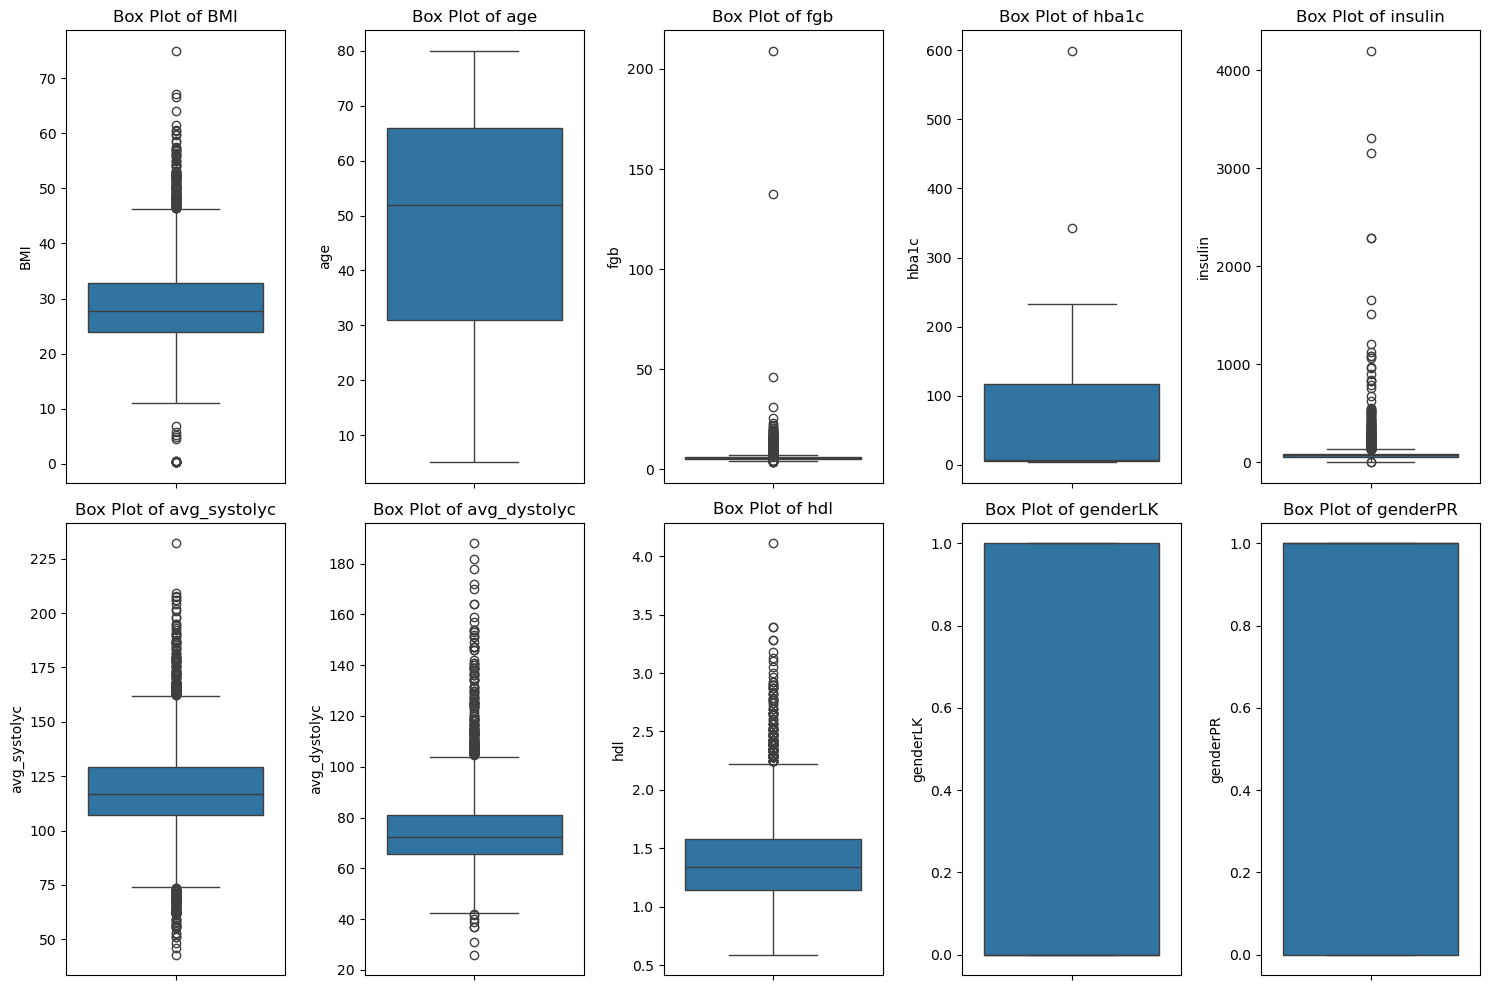

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ganti 'path/to/your/data_labeled.csv' dengan lokasi file Anda
df = pd.read_csv('Dataset/datalabel_withgender.csv', delimiter=';')

# Tampilkan beberapa baris pertama untuk memastikan data termuat
print(df.head())

# Pilih kolom numerik yang ingin Anda periksa (kecuali ID dan kolom target)
numeric_features = [ 'BMI', 'age', 'fgb', 'hba1c', 'insulin', 'avg_systolyc', 'avg_dystolyc', 'hdl' , 'genderLK','genderPR']

# Buat box plot untuk setiap fitur
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 5, i)
    sns.boxplot(y=df[feature])
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

df = pd.read_csv("Dataset/datalabel_withgender.csv", delimiter=";")

# --- 1. Copy data untuk cleaning ---
df_clean = df.copy()

# Buang error input (outlier yang jelas salah, bukan medis ekstrem)
df_clean = df_clean[df_clean['tinggi'] > 80]        # tinggi minimal 80 cm
df_clean = df_clean[df_clean['berat'] > 10]         # berat minimal 10 kg
df_clean = df_clean[df_clean['BMI'] < 70]           # buang BMI ekstrem
df_clean = df_clean[df_clean['insulin'] < 2000]     # insulin wajar
df_clean = df_clean[(df_clean['age'] > 0) & (df_clean['age'] < 100)]  # usia wajar

print(f"Jumlah data awal: {df.shape[0]}")
print(f"Jumlah data setelah cleaning: {df_clean.shape[0]}")

# --- 2. Transformasi log untuk kolom yang sangat skewed ---
df_clean['insulin_log'] = np.log1p(df_clean['insulin'])  # log(1+x)

# --- 3. Scaling dengan RobustScaler ---
scaler = RobustScaler()
num_cols = ['berat','tinggi','BMI','age','insulin_log',
            'avg_systolyc','avg_dystolyc','hdl']

df_scaled = df_clean.copy()
df_scaled[num_cols] = scaler.fit_transform(df_clean[num_cols])

# --- 4. Simpan hasil scaling ---
df_scaled.to_csv("data_scaled_gender.csv", index=False)

print("\nContoh hasil scaling:")
print(df_scaled[num_cols].head())


Jumlah data awal: 5538
Jumlah data setelah cleaning: 5514

Contoh hasil scaling:
      berat    tinggi       BMI       age  insulin_log  avg_systolyc  \
0  0.319298  0.903448 -0.087273 -0.257143     0.599974      0.659091   
1  0.842105  0.537931  0.648951  0.400000     1.123916     -0.090909   
2 -0.294737 -0.931034  0.217063 -0.228571     0.705801     -0.409091   
3  0.449123  0.475862  0.270769 -0.514286    -0.053707      0.022727   
4  0.901754 -0.724138  1.659301  0.457143     0.115182      1.272727   

   avg_dystolyc       hdl  
0      1.419355 -0.409091  
1      0.193548  0.477273  
2      0.322581 -0.159091  
3      0.096774 -0.340909  
4      0.322581 -0.568182  


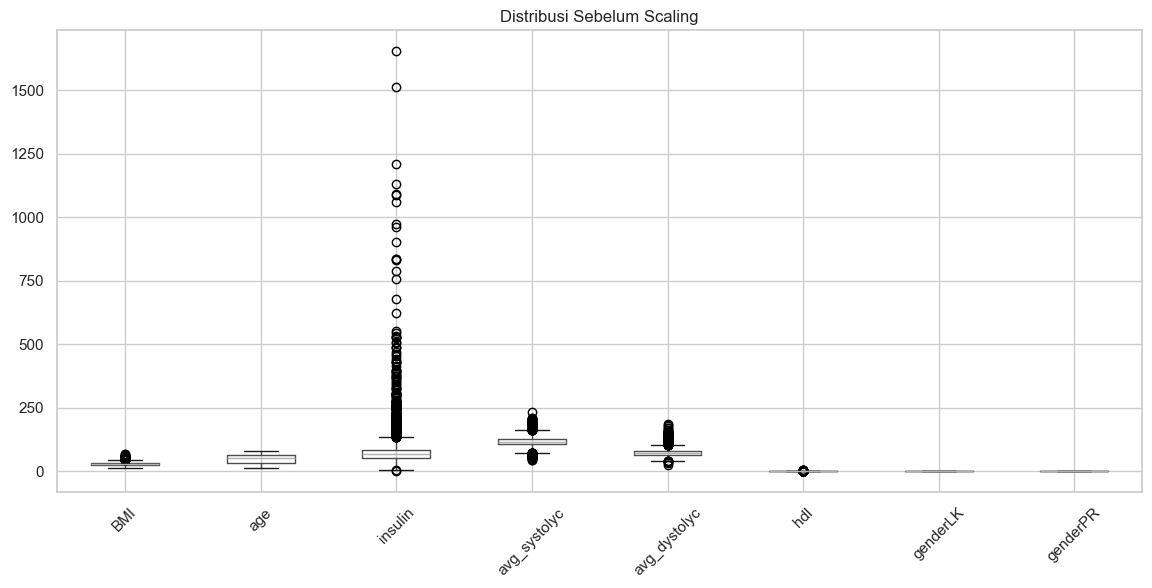

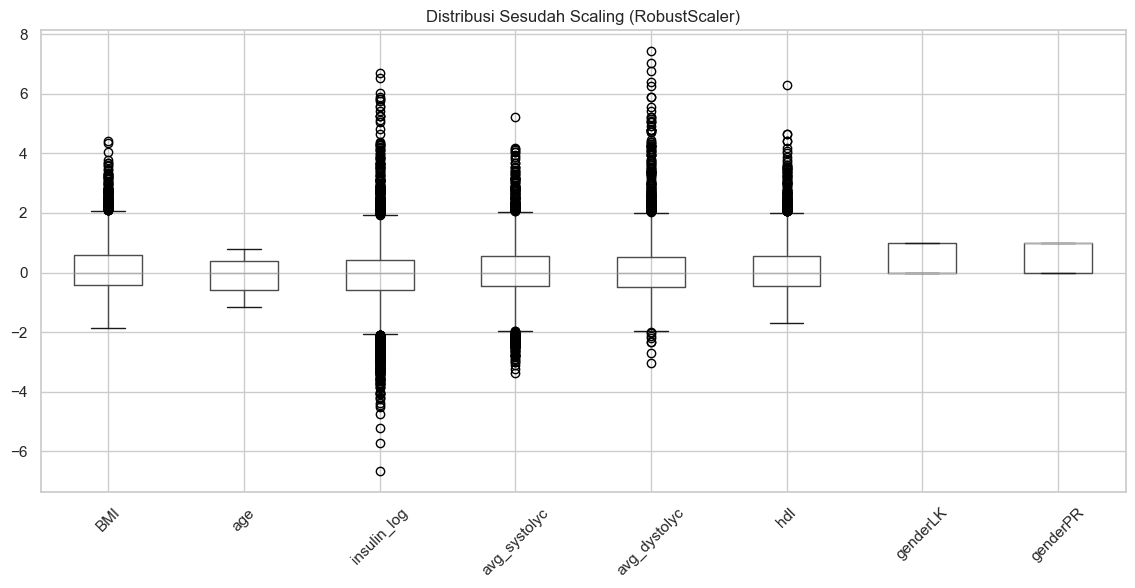

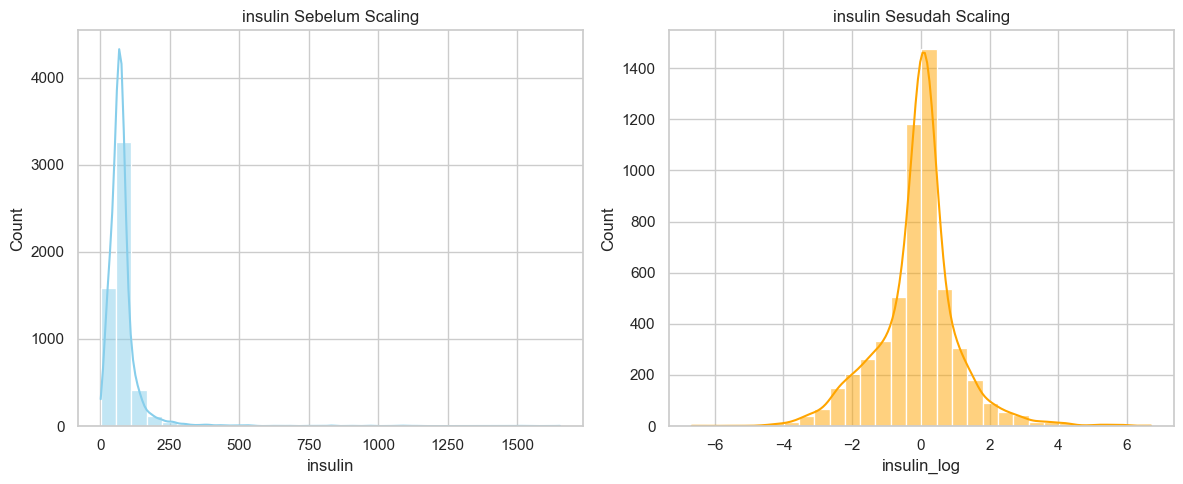

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Atur style biar lebih enak dilihat
sns.set(style="whitegrid")

# Kolom numerik yang mau dicek
num_cols = ['BMI','age','insulin','avg_systolyc','avg_dystolyc','hdl','genderLK','genderPR']

# --- 1. Boxplot sebelum scaling ---
plt.figure(figsize=(14,6))
df_clean[num_cols].boxplot()
plt.title("Distribusi Sebelum Scaling")
plt.xticks(rotation=45)
plt.show()

# --- 2. Boxplot sesudah scaling ---
plt.figure(figsize=(14,6))
df_scaled[[c if c!="insulin" else "insulin_log" for c in num_cols]].boxplot()
plt.title("Distribusi Sesudah Scaling (RobustScaler)")
plt.xticks(rotation=45)
plt.show()

# --- 3. Histogram contoh sebelum vs sesudah (misal BMI) ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df_clean['insulin'], bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("insulin Sebelum Scaling")

sns.histplot(df_scaled['insulin_log'], bins=30, kde=True, ax=axes[1], color="orange")
axes[1].set_title("insulin Sesudah Scaling")

plt.tight_layout()
plt.show()


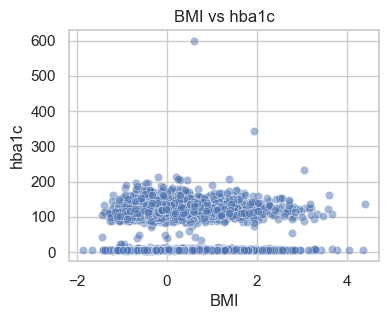

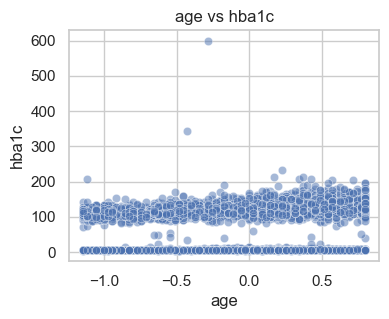

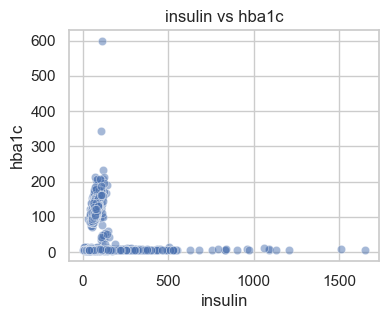

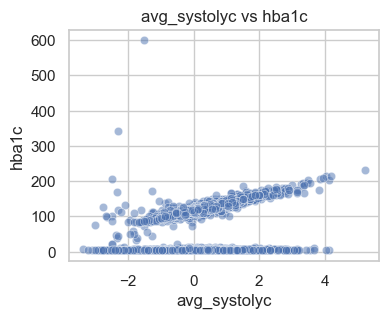

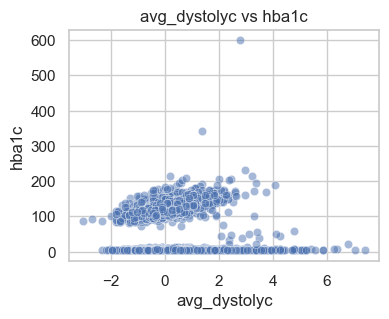

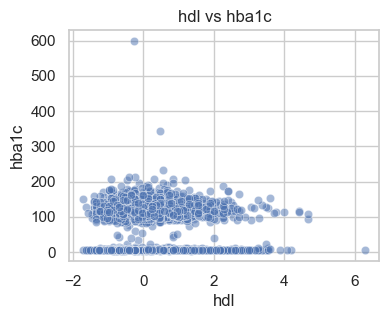

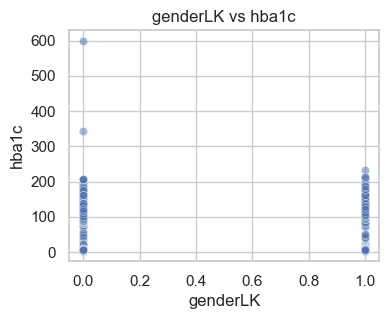

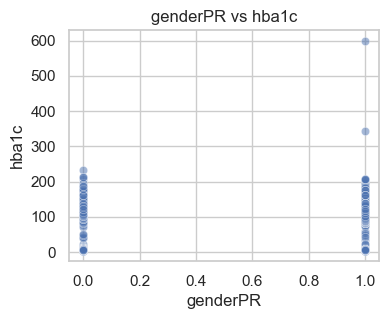

        Feature  Pearson (linear)  Spearman (monotonic)
0           BMI             0.036                 0.130
1           age             0.026                 0.203
2       insulin            -0.056                 0.292
3  avg_systolyc             0.203                 0.326
4  avg_dystolyc             0.021                 0.153
5           hdl            -0.017                -0.015
6      genderLK             0.022                 0.046
7      genderPR            -0.022                -0.046


In [7]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Misalnya dataset kamu sudah di df_scaled
# Target (misalnya HbA1c untuk labeling)
target = "hba1c"
features = ["BMI","age","insulin","avg_systolyc","avg_dystolyc","hdl","genderLK","genderPR"]

results = []

for col in features:
    # Hitung korelasi Pearson & Spearman
    pearson_corr, _ = pearsonr(df_scaled[col], df_scaled[target])
    spearman_corr, _ = spearmanr(df_scaled[col], df_scaled[target])
    
    results.append({
        "Feature": col,
        "Pearson (linear)": round(pearson_corr, 3),
        "Spearman (monotonic)": round(spearman_corr, 3)
    })
    
    # Scatter plot
    plt.figure(figsize=(4,3))
    sns.scatterplot(x=df_scaled[col], y=df_scaled[target], alpha=0.5)
    plt.title(f"{col} vs {target}")
    plt.show()

# Tabel hasil
results_df = pd.DataFrame(results)
print(results_df)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25352\246083296.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_scaleds[col].fillna(median_val, inplace=True)


Menangani nilai non-numerik di kolom 'BMI' dan mengisinya dengan median (-0.0783216783216782).
Menangani nilai non-numerik di kolom 'age' dan mengisinya dengan median (0.1142857142857142).
Menangani nilai non-numerik di kolom 'insulin_log' dan mengisinya dengan median (0.0576412715058951).
Menangani nilai non-numerik di kolom 'avg_systolyc' dan mengisinya dengan median (-0.0454545454545454).
Menangani nilai non-numerik di kolom 'avg_dystolyc' dan mengisinya dengan median (-0.064516129032258).

Pembersihan data selesai.

Model Random Forest berhasil dilatih.

Hasil Feature Importance:
          Fitur  Importance
2   insulin_log    0.312827
0           BMI    0.185719
4  avg_dystolyc    0.181184
1           age    0.163917
3  avg_systolyc    0.156353


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25352\246083296.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Fitur", data=feat_imp, palette="viridis")


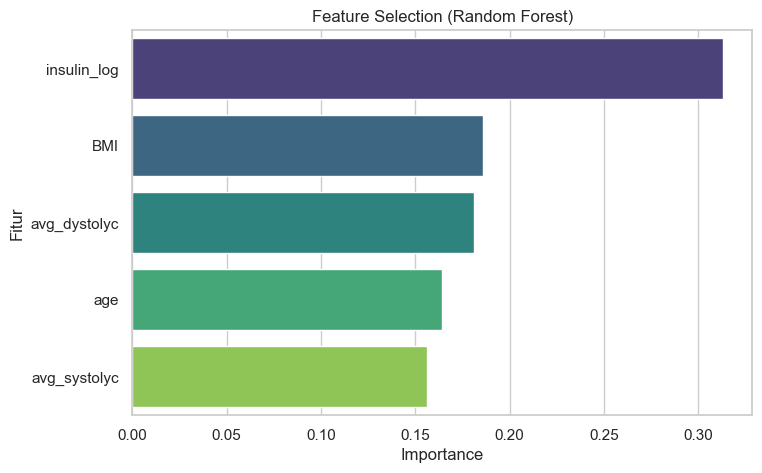

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Baca dataset
df_scaleds = pd.read_csv("Dataset/data_scaled_gender.csv", delimiter=";")

# --- LANGKAH PEMBERSIHAN DATA (TAMBAHAN) ---
# Daftar kolom fitur yang akan digunakan
feature_columns = ['BMI','age','insulin_log','avg_systolyc','avg_dystolyc']

# Loop melalui setiap kolom fitur untuk memastikan semuanya numerik
for col in feature_columns:
    # Ubah paksa menjadi numerik. Nilai yang gagal akan menjadi NaN (Not a Number)
    df_scaleds[col] = pd.to_numeric(df_scaleds[col], errors='coerce')
    
    # Cek apakah ada nilai NaN yang muncul setelah konversi
    if df_scaleds[col].isnull().sum() > 0:
        # Isi nilai NaN dengan median dari kolom tersebut
        median_val = df_scaleds[col].median()
        df_scaleds[col].fillna(median_val, inplace=True)
        print(f"Menangani nilai non-numerik di kolom '{col}' dan mengisinya dengan median ({median_val}).")

print("\nPembersihan data selesai.\n")
# ---------------------------------------------


# --- 1. Pisahkan fitur dan label (setelah dibersihkan) ---
X = df_scaleds[feature_columns]
y = df_scaleds['Status']

# --- 2. Encode label jadi angka ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- 3. Random Forest untuk feature importance ---
# Kode ini sekarang seharusnya berjalan tanpa error
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y_encoded)

print("Model Random Forest berhasil dilatih.\n")

# --- 4. Ambil importance ---
importances = rf.feature_importances_
feature_names = X.columns
feat_imp = pd.DataFrame({'Fitur': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

# --- 5. Plot hasilnya ---
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Fitur", data=feat_imp, palette="viridis")
plt.title("Feature Selection (Random Forest)")
# plt.show() # Gunakan ini jika menjalankan sebagai script .py
plt.savefig("feature_importance.png", bbox_inches='tight') # Menyimpan plot ke file

print("Hasil Feature Importance:")
print(feat_imp)